## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

## STEP1: Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname,-1)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

In [2]:
image = cv2.imread('../test_images/straight_lines1.jpg')
img_size = (image.shape[1], image.shape[0])
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "../camera_cal/wide_dist_pickle.p", "wb" ) )

## STEP2: Apply distortion correction

In [3]:
dist_pickle = pickle.load( open( "../camera_cal/wide_dist_pickle.p", "rb" ) )
mtx= dist_pickle["mtx"]
dist = dist_pickle["dist"]

print(dist)

[[-0.24688833 -0.02372814 -0.00109843  0.00035105 -0.00259139]]


In [4]:
undstimage = cv2.undistort(image, mtx, dist, None, mtx)

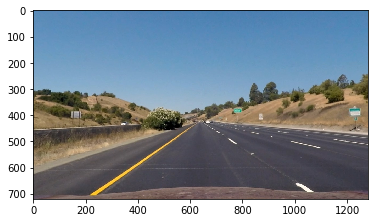

In [7]:
#plt.imshow(undstimage, cmap='gray' )
#cv2.imshow('image',undstimage)
plt.imshow(cv2.cvtColor(undstimage, cv2.COLOR_BGR2RGB))

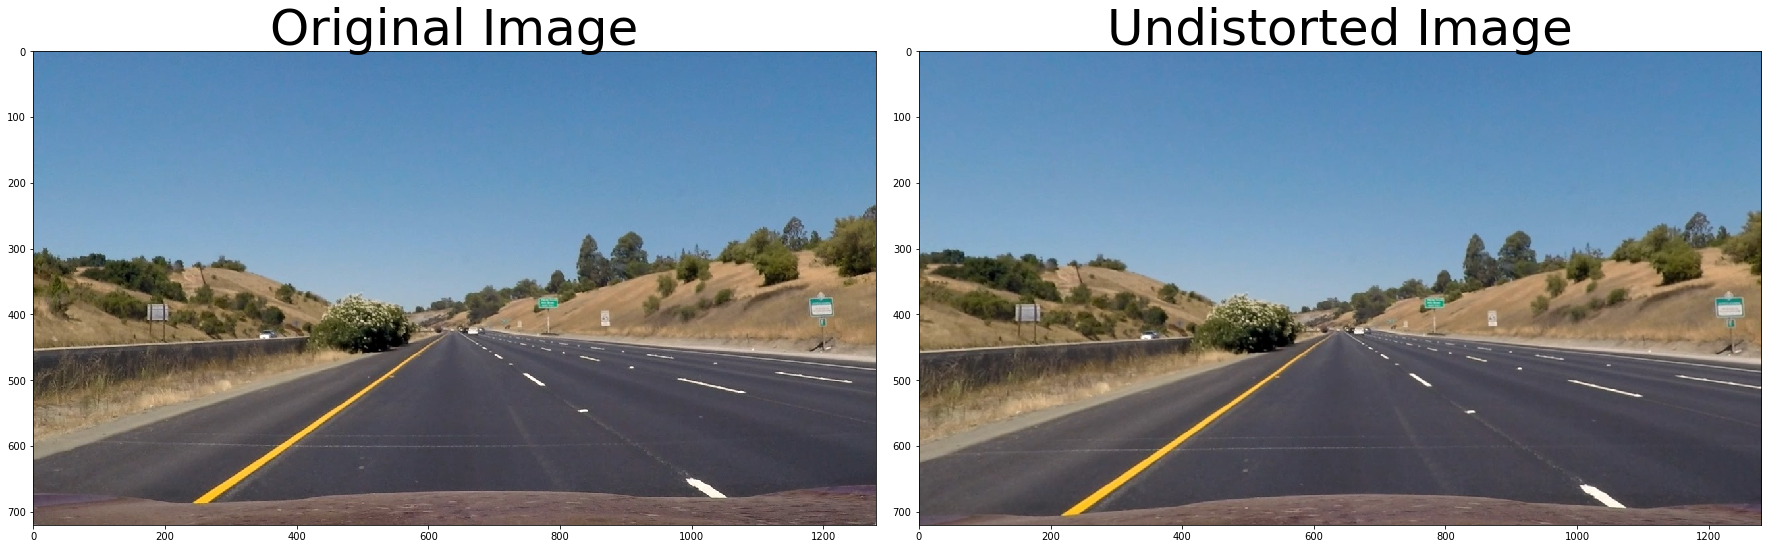

In [8]:
def undistort(img):
    dist_pickle = pickle.load( open( "../camera_cal/wide_dist_pickle.p", "rb" ) )
    mtx= dist_pickle["mtx"]
    dist = dist_pickle["dist"]
    undstimage = cv2.undistort(img, mtx, dist, None, mtx)
    return undstimage

image = cv2.imread('../test_images/straight_lines1.jpg')
undstimage = undistort(image)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(cv2.cvtColor(undstimage, cv2.COLOR_BGR2RGB))
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


## STEP3: Use color transforms, gradients, etc., to create a thresholded binary image.

### Extract frames from the project video for testing

In [10]:
import cv2
print(cv2.__version__)
vidcap = cv2.VideoCapture("../project_video.mp4")
success,image = vidcap.read()
count = 0
success = True
while success:
    cv2.imwrite("../video_frames/frame%d.jpg" % count, image)     # save frame as JPEG file
    success,image = vidcap.read()
    #print('Read a new frame: ', success)
    count += 1

4.0.0


#### Experimenting with various color transforms

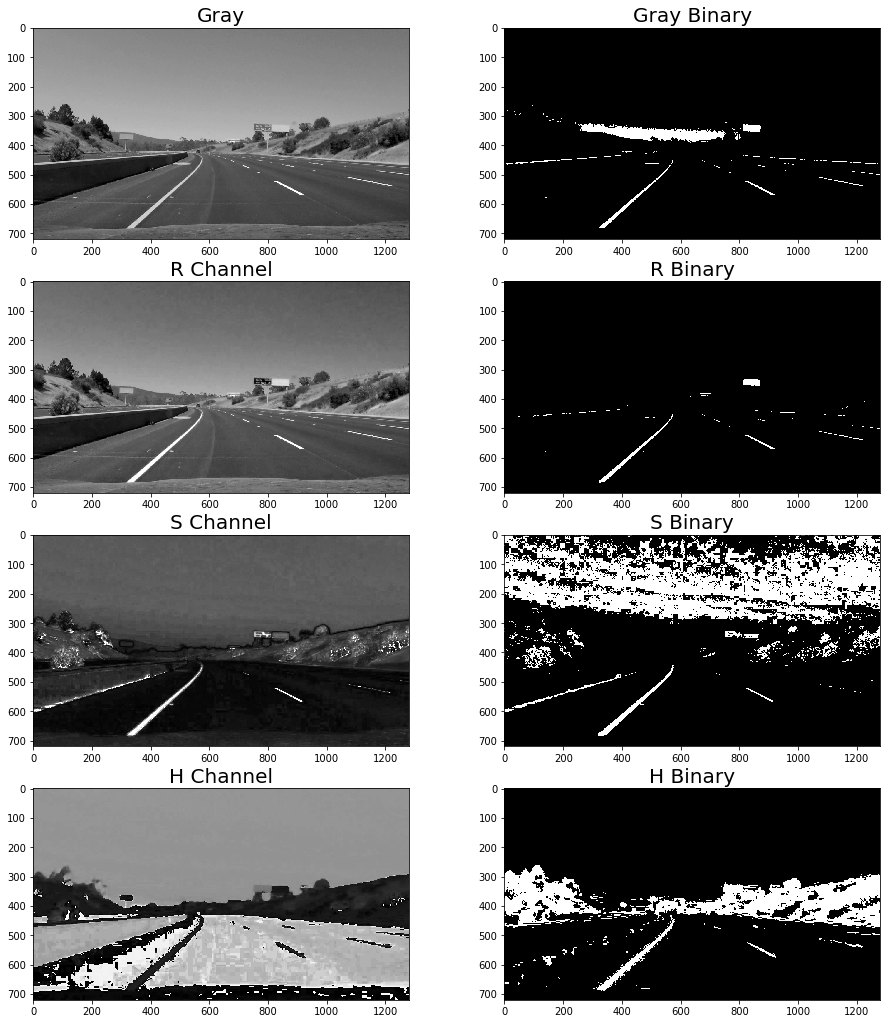

In [18]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image = mpimg.imread('../video_frames/frame0.jpg')
#plt.imshow(image)
R = image[:,:,0]
G = image[:,:,1]
B = image[:,:,2]

hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
H = hls[:,:,0]
L = hls[:,:,1]
S = hls[:,:,2]

#Gray scaling and thresholding
thresh = (180, 255)
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
graybinary = np.zeros_like(gray)
graybinary[(gray > thresh[0]) & (gray <= thresh[1])] = 1

#R channel and thresholding
thresh = (200, 255)
Rbinary = np.zeros_like(R)
Rbinary[(R > thresh[0]) & (R <= thresh[1])] = 1

#S channel and thresholding
thresh = (90, 255)
Sbinary = np.zeros_like(S)
Sbinary[(S > thresh[0]) & (S <= thresh[1])] = 1


#H channel and thresholding
thresh = (15, 100)
Hbinary = np.zeros_like(H)
Hbinary[(H > thresh[0]) & (H <= thresh[1])] = 1

fig = plt.figure(figsize=(20,15))

##ax1.imshow(mpimg.imread('test_images_output/'+imagespre[0]))

##f, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8) = plt.subplots(8, 2, figsize=(24, 9))
## fig.tight_layout()
ax1 = fig.add_subplot(4,2,1)
ax1.imshow(gray, cmap='gray')
ax1.set_title('Gray', fontsize=20)

ax2 = fig.add_subplot(4,2,2)
ax2.imshow(graybinary, cmap='gray')
ax2.set_title('Gray Binary', fontsize=20)

ax3 = fig.add_subplot(4,2,3)
ax3.imshow(R, cmap='gray')
ax3.set_title('R Channel', fontsize=20)

ax4 = fig.add_subplot(4,2,4)
ax4.imshow(Rbinary, cmap='gray')
ax4.set_title('R Binary', fontsize=20)

ax5 = fig.add_subplot(4,2,5)
ax5.imshow(S, cmap='gray')
ax5.set_title('S Channel', fontsize=20)

ax6 = fig.add_subplot(4,2,6)
ax6.imshow(Sbinary, cmap='gray')
ax6.set_title('S Binary', fontsize=20)

ax7 = fig.add_subplot(4,2,7)
ax7.imshow(H, cmap='gray')
ax7.set_title('H Channel', fontsize=20)

ax8 = fig.add_subplot(4,2,8)
ax8.imshow(Hbinary, cmap='gray')
ax8.set_title('H Binary', fontsize=20)

plt.subplots_adjust(left=0., right=.6, top=0.9, bottom=0.)

### Experimenting with Gradients

In [19]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
   # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output


def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
   # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel))
    abs_sobely = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel))
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    direction = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(direction)
    binary_output[(direction >= thresh[0]) & (direction <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output
    #return dir_binary

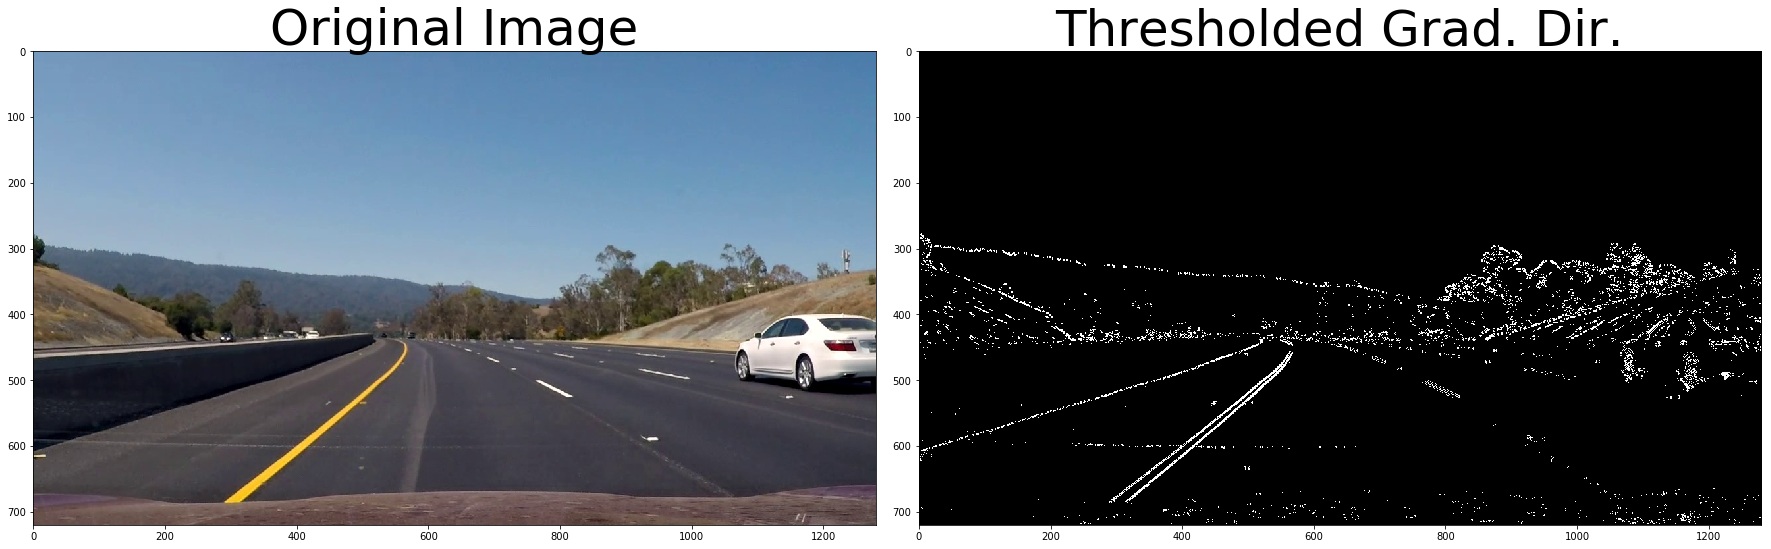

In [35]:
# Choose a Sobel kernel size
ksize = 3 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(20, 100))
grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(20, 100))
mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(20, 100))
dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7,1.3)) #thresh=(0, np.pi/2)

combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Thresholded Grad. Dir.', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Combining R binary and Combined gradients

In [46]:
def Color_gradient_thresholding(img, plot=False):
    ksize = 3 # Choose a larger odd number to smooth gradient measurements
    R = img[:,:,0]

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=(20, 100))
    mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=(20, 100))
    dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=(0.7,1.5)) #thresh=(0, np.pi/2)
    
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    #R channel and thresholding
    thresh = (200, 255)
    Rbinary = np.zeros_like(R)
    Rbinary[(R > thresh[0]) & (R <= thresh[1])] = 1
    
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    
    #combining grandient binaries and R channel binary
    combined_binary = np.zeros_like(combined)
    combined_binary[(Rbinary == 1) | (combined == 1)] = 1
    
    if plot == True:
        f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20,10))
        ax1.set_title('Original image')
        ax1.imshow(img)
        ax2.set_title('Combined Gradients')
        ax2.imshow(combined, cmap='gray')
        ax3.set_title('R Binary')
        ax3.imshow(Rbinary, cmap='gray')
        ax4.set_title('Combined Binary')
        ax4.imshow(combined_binary, cmap='gray')
        
    return combined_binary

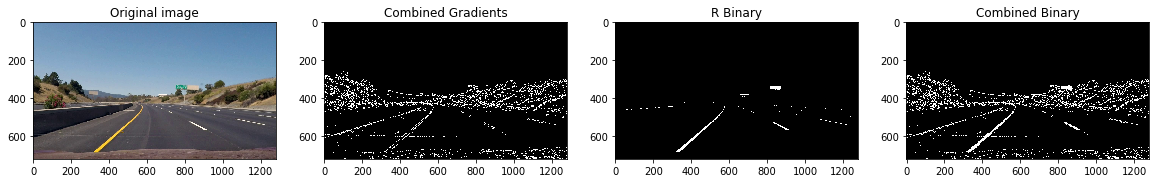

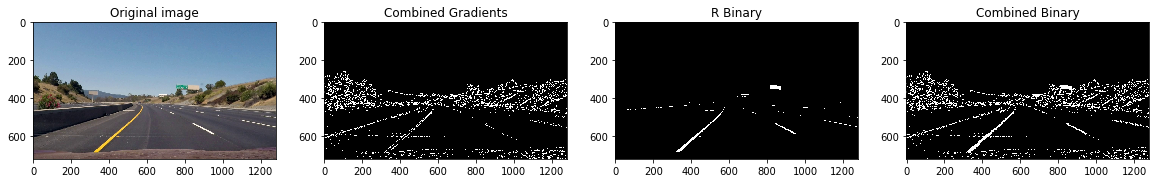

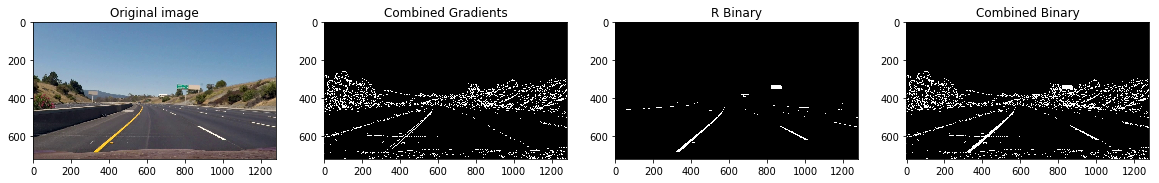

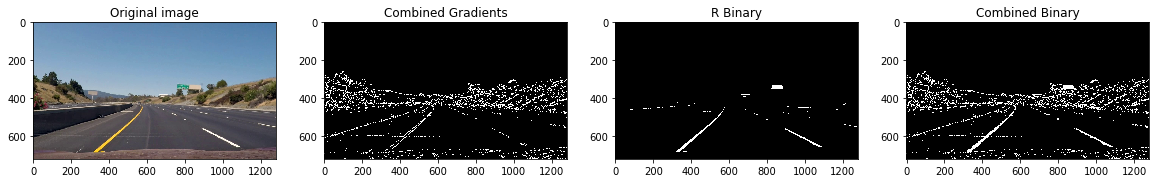

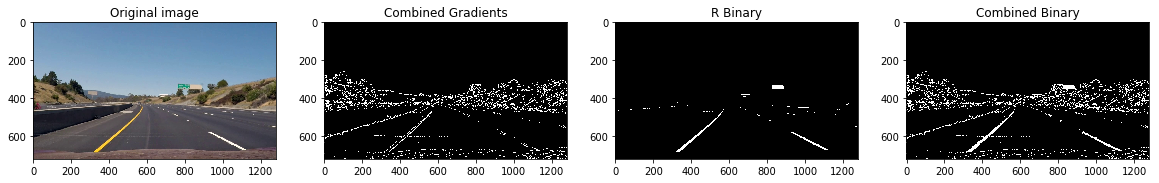

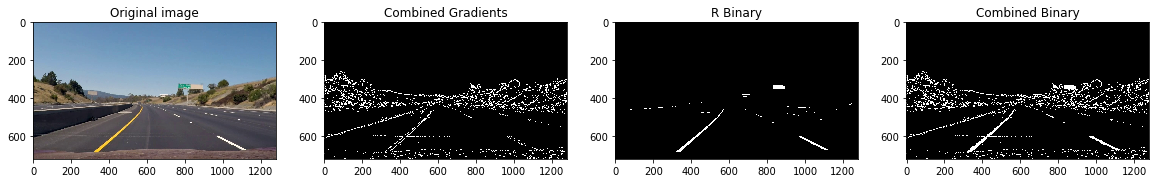

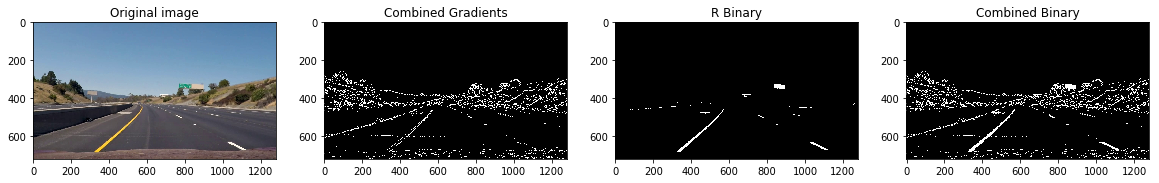

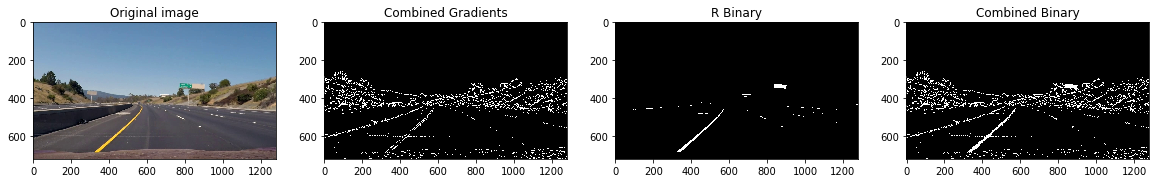

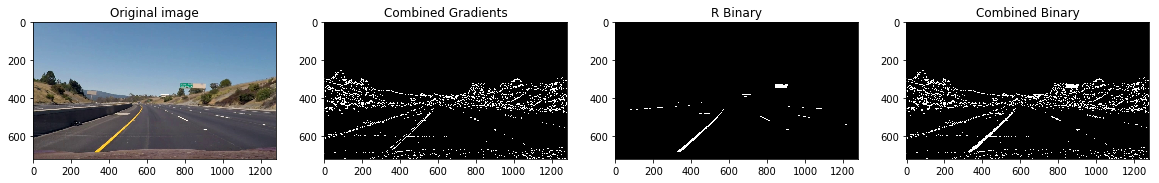

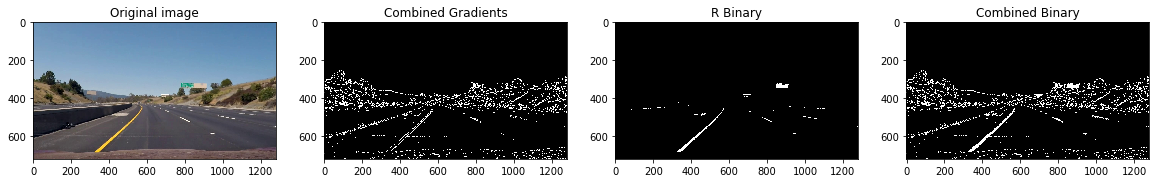

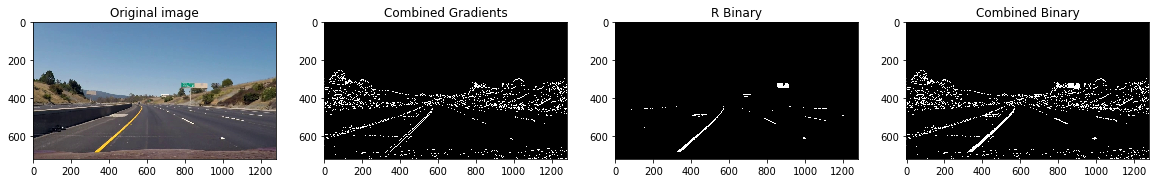

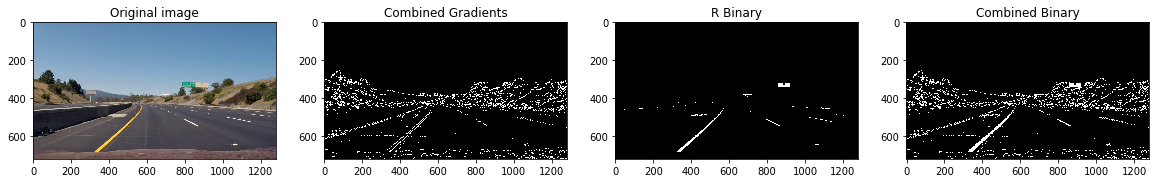

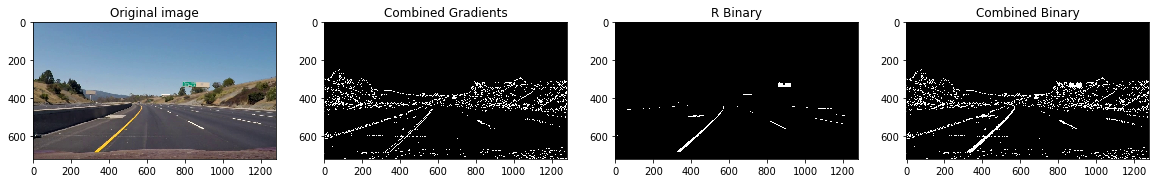

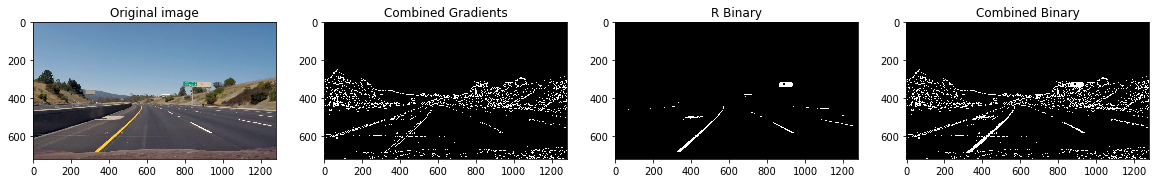

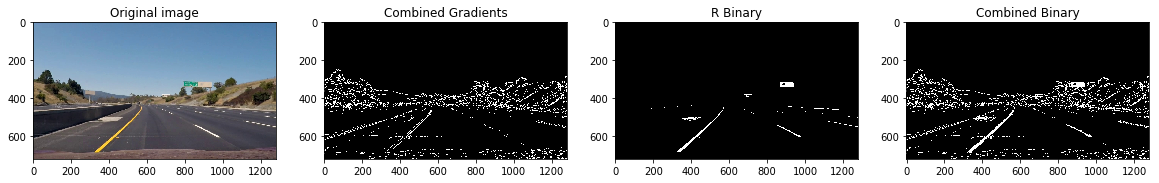

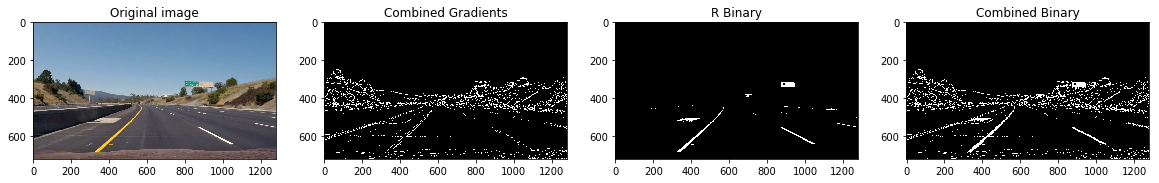

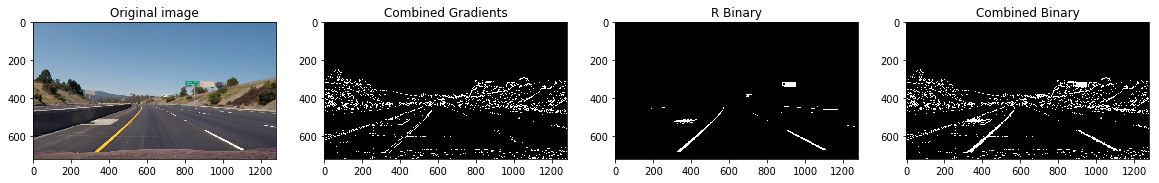

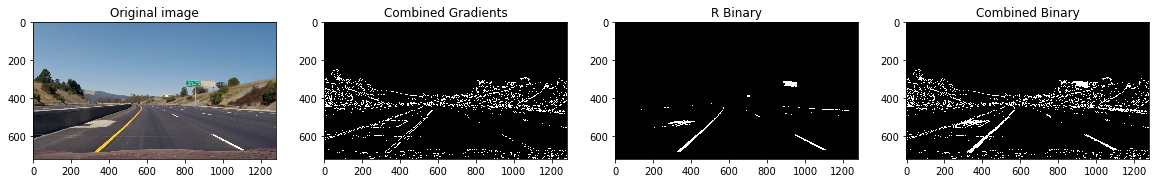

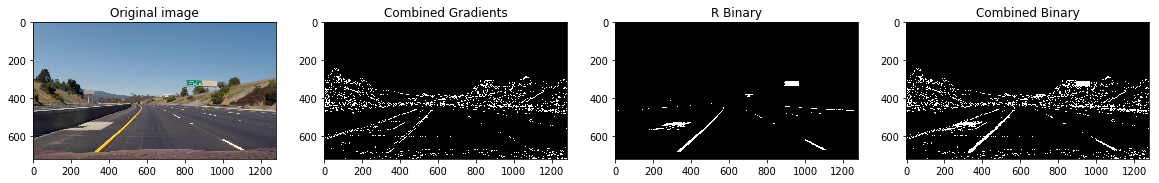

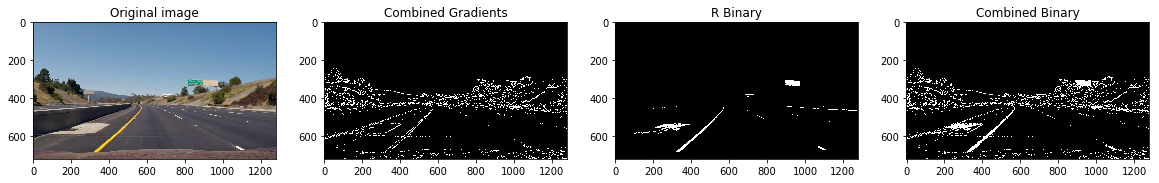

In [47]:
for frame in range(0,20):
    image = mpimg.imread("../video_frames/frame%d.jpg" % frame)
    combined_binary = Color_gradient_thresholding(image, True)

## STEP4: Apply a perspective transform to rectify binary image ("birds-eye view")

In [49]:
img_size = (image.shape[1], image.shape[0])
img_size[0]

1280

In [59]:
def birds_eye_view(img, plot=False):
    offset = 200 # offset for dst points
    img_size = (img.shape[1], img.shape[0])
    
    l_upper_corner  = [568,470]
    r_upper_corner = [717,470]
    l_lower_corner  = [300,650]
    r_lower_corner = [1040,650]
    
    src = np.float32([l_upper_corner, l_lower_corner, r_upper_corner, r_lower_corner])
    dst = np.float32([[offset,0], [offset,650], [img_size[0]-offset,0], [img_size[0]-offset,680]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR) 
    
    if plot == True:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 12))
        f.tight_layout()
        ax1.imshow(img, cmap='gray')
        ax1.set_title('Original Image', fontsize=50)
        ax2.imshow(warped,cmap='gray')
        ax2.set_title('Warped Image', fontsize=50)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        
    return warped, M                  

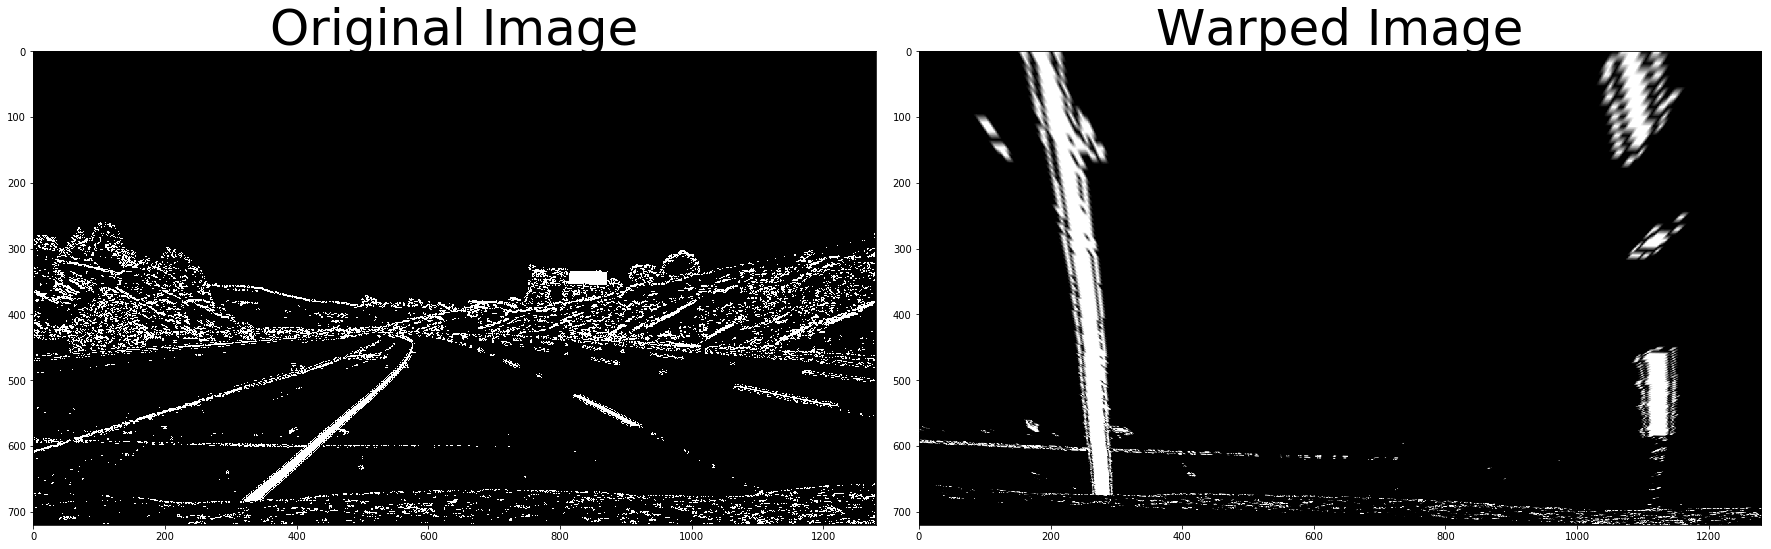

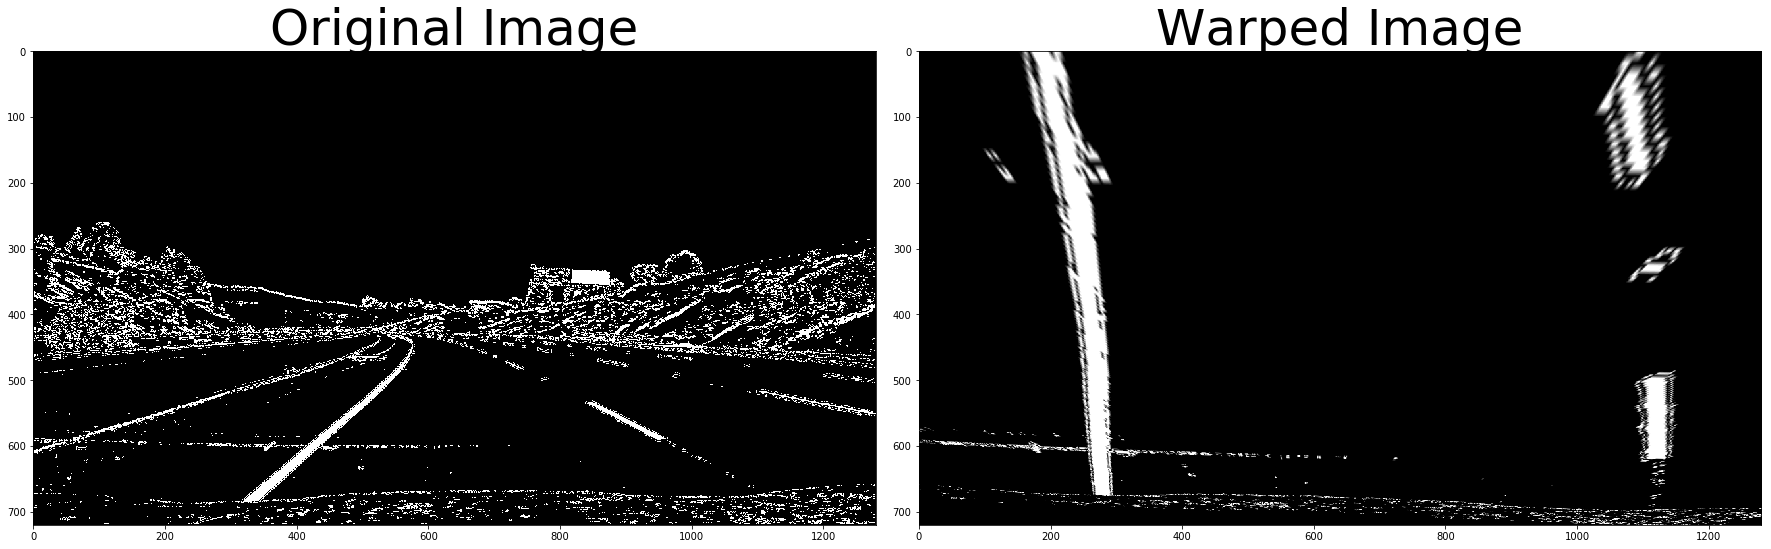

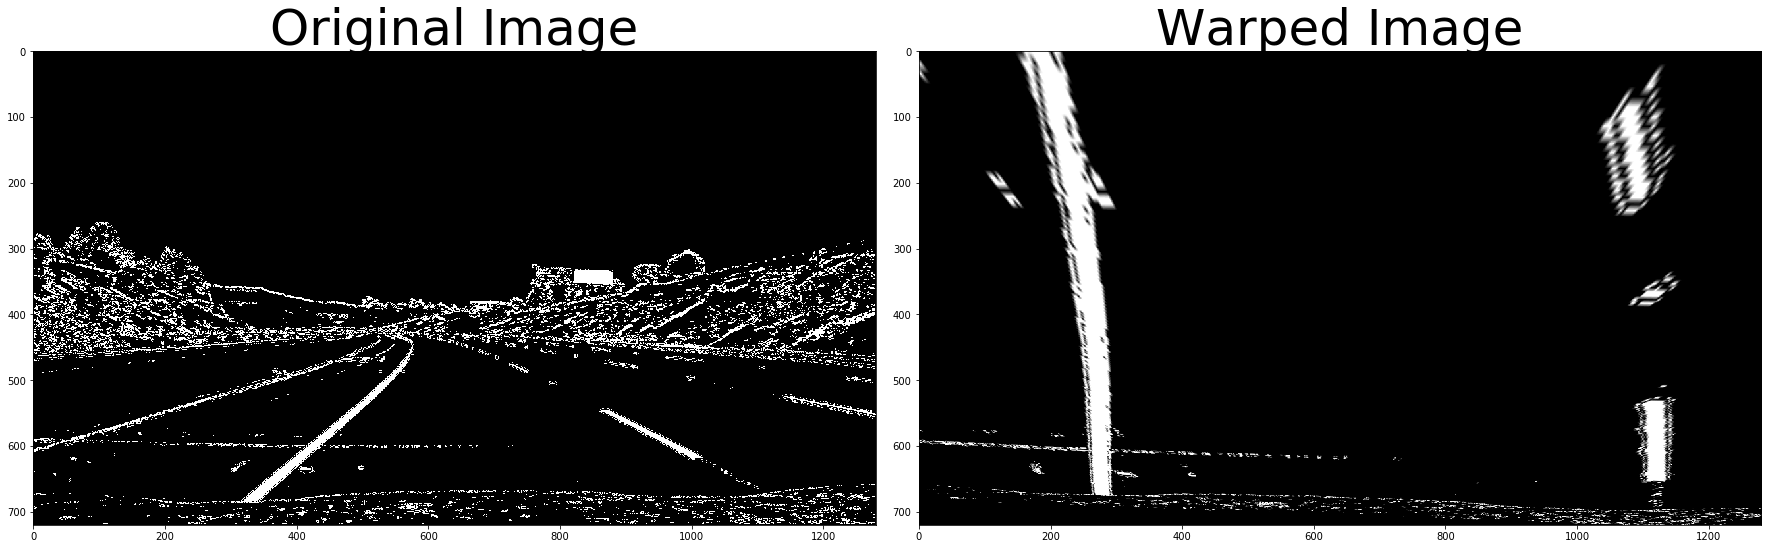

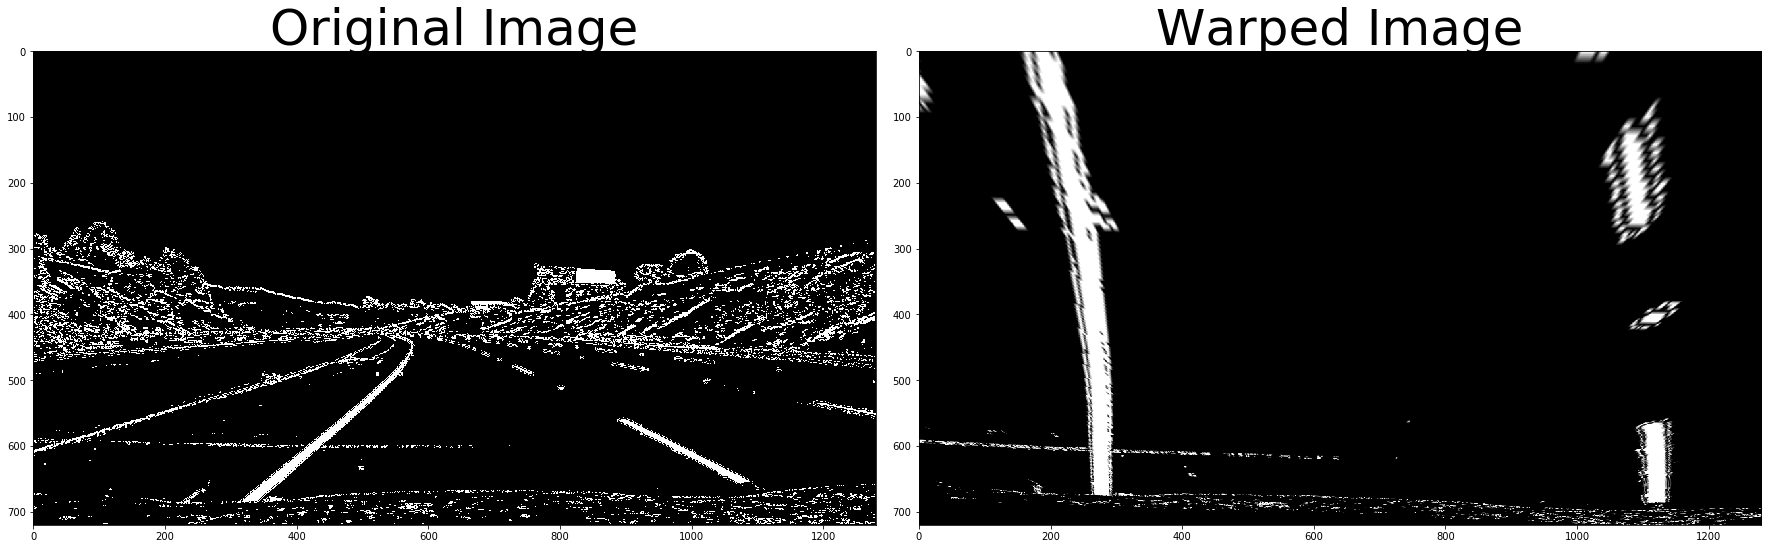

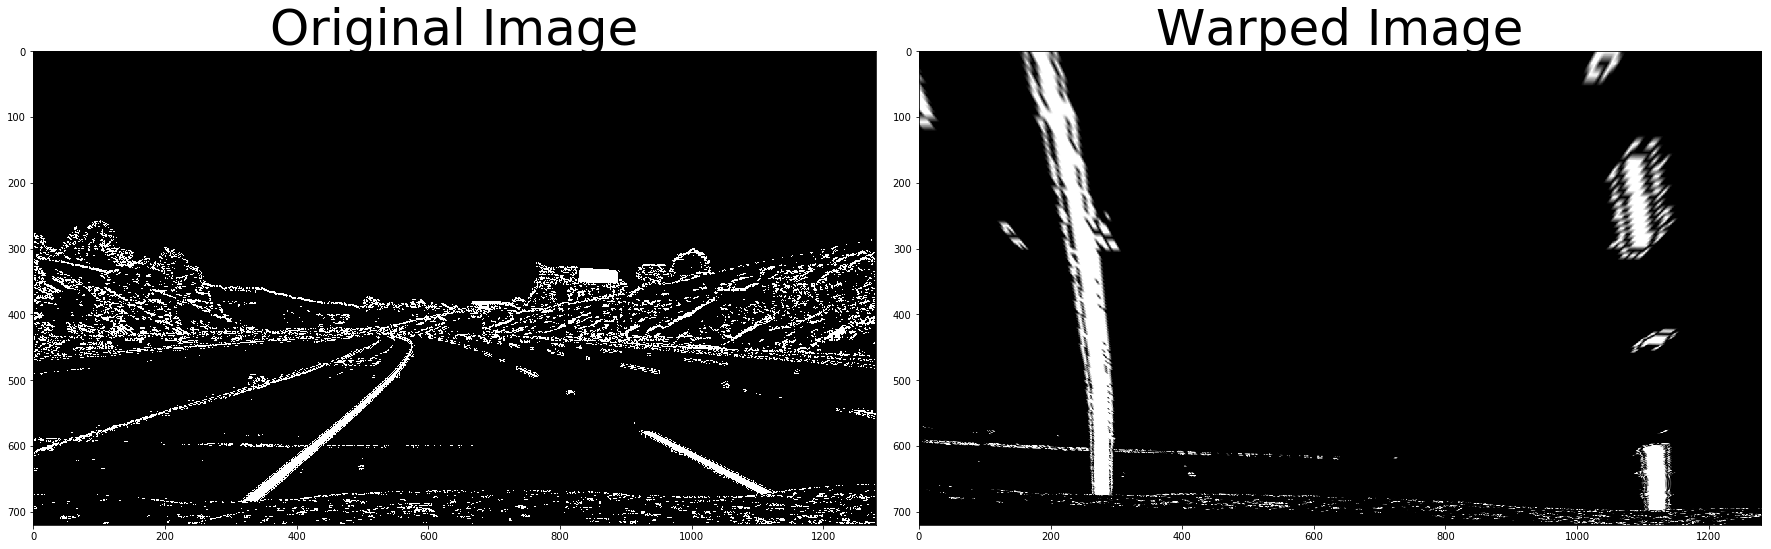

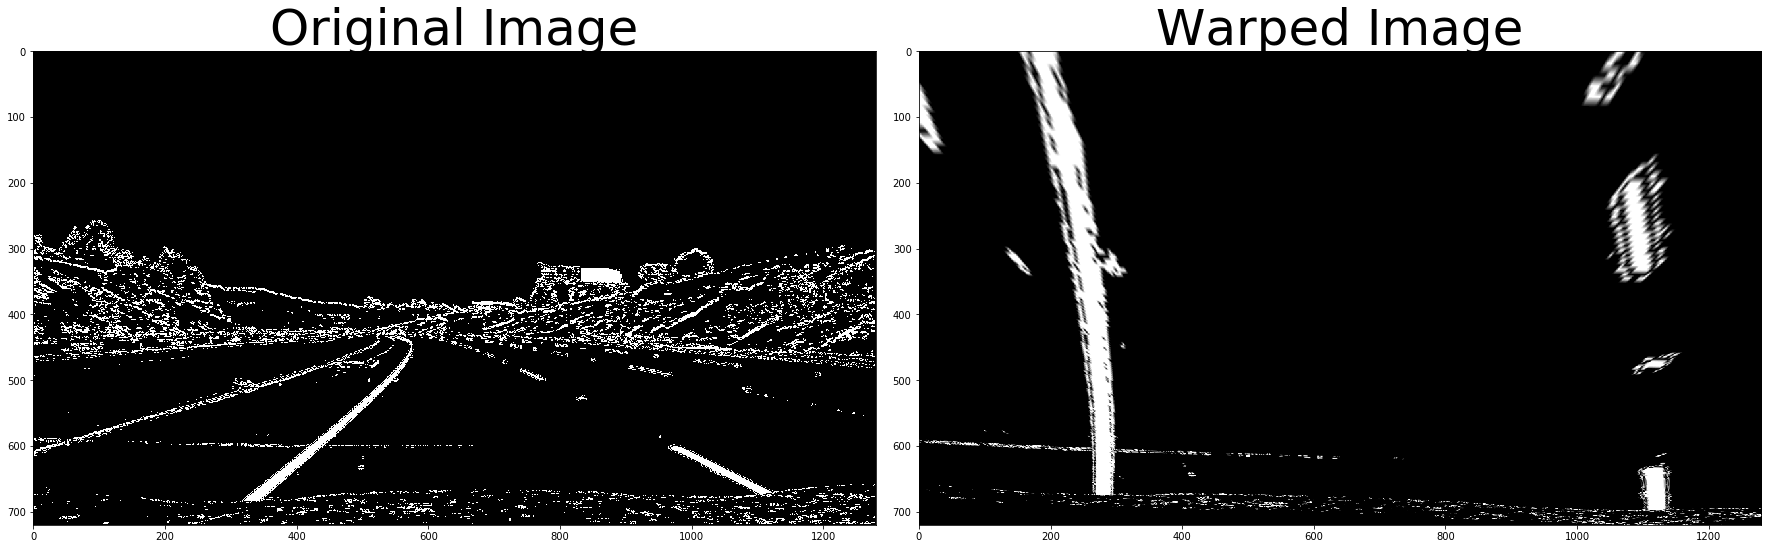

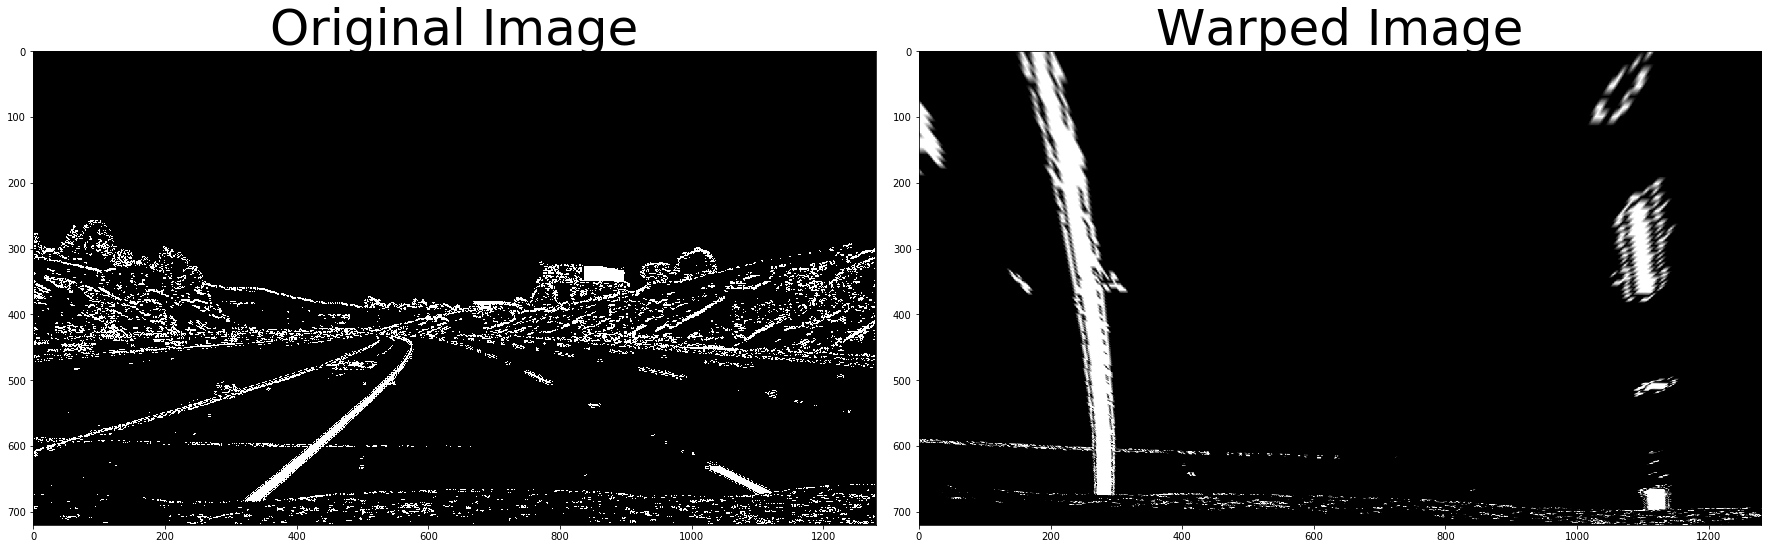

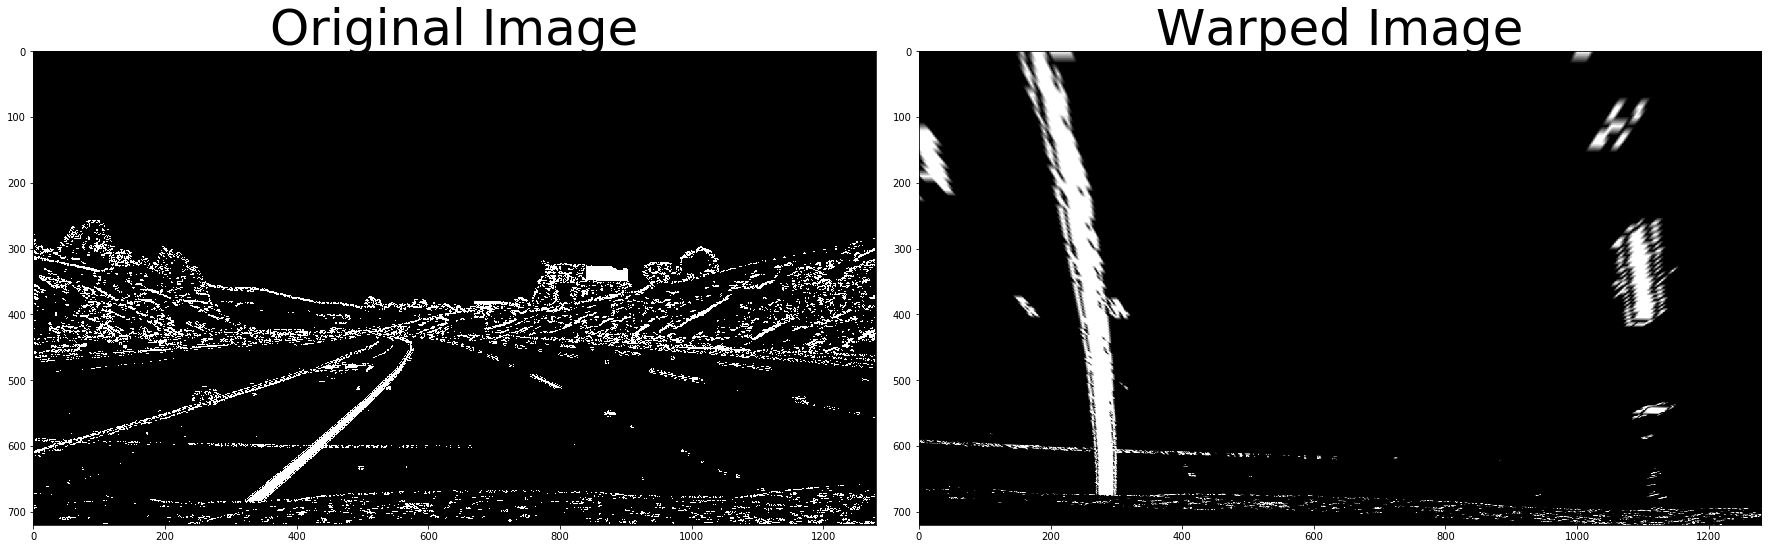

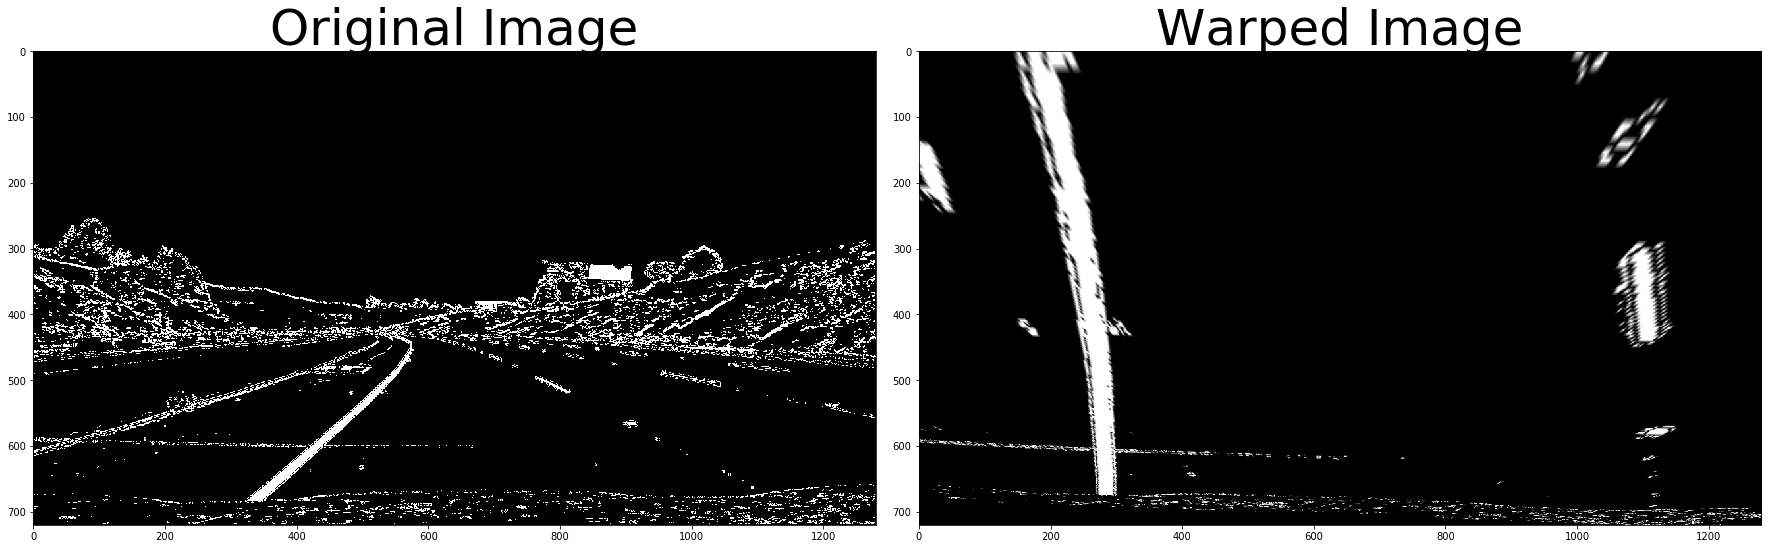

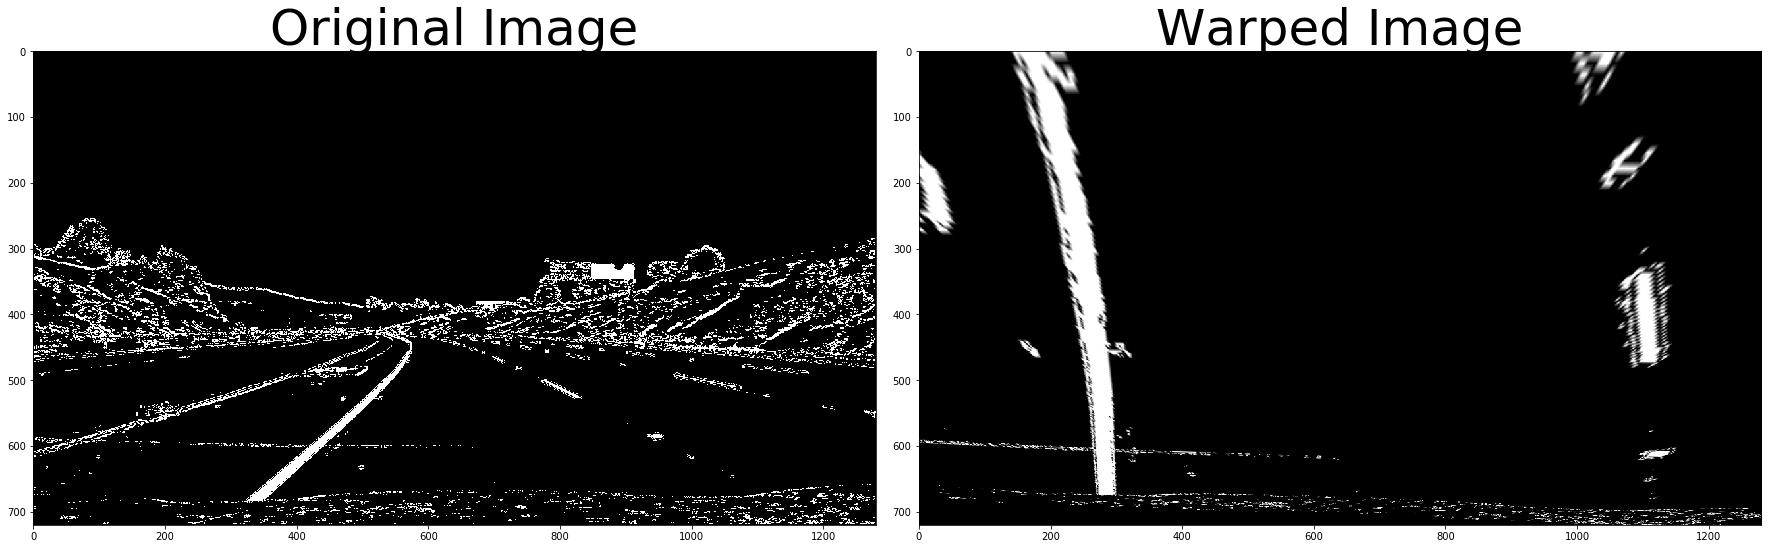

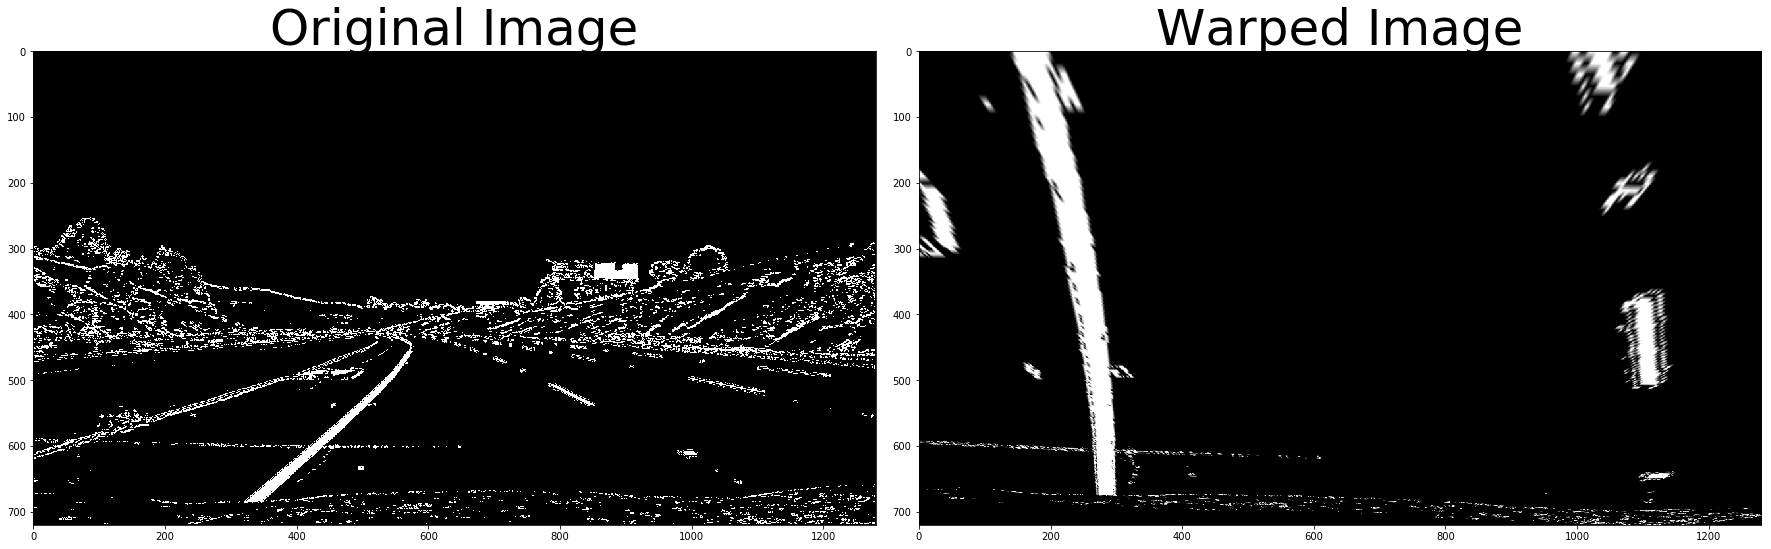

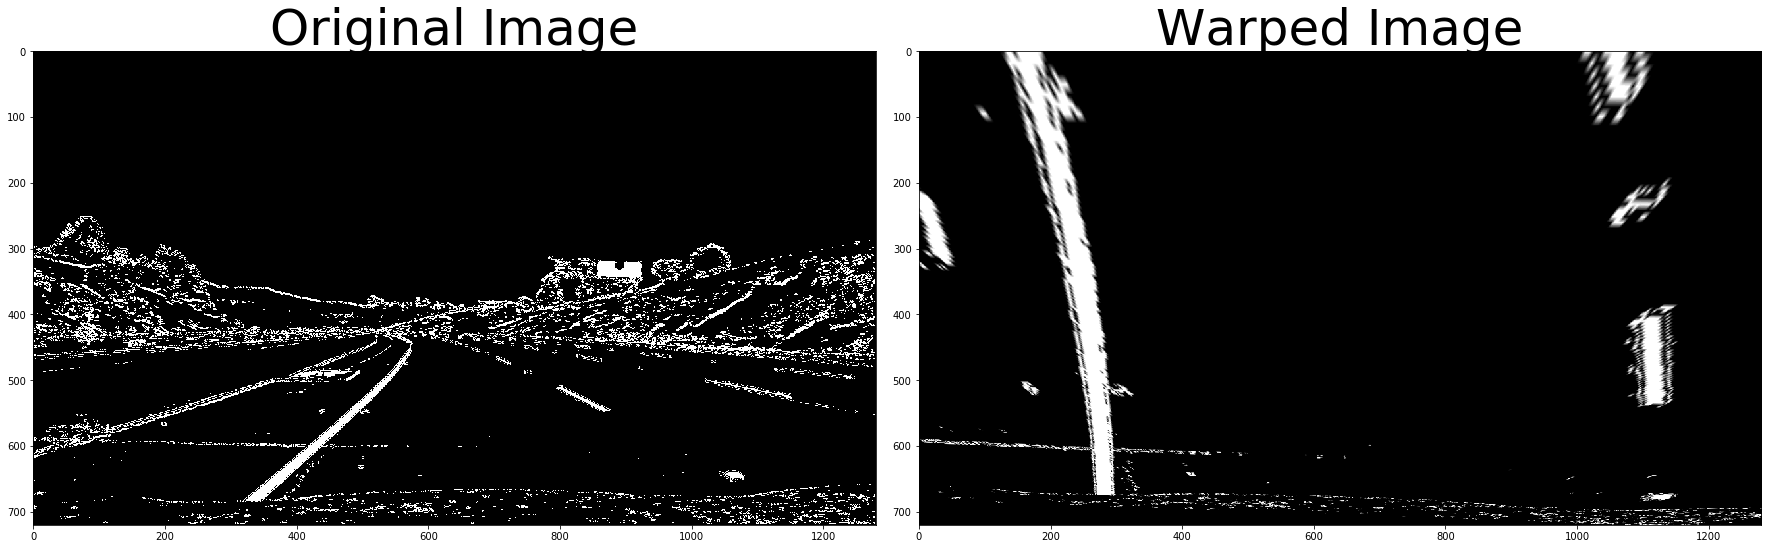

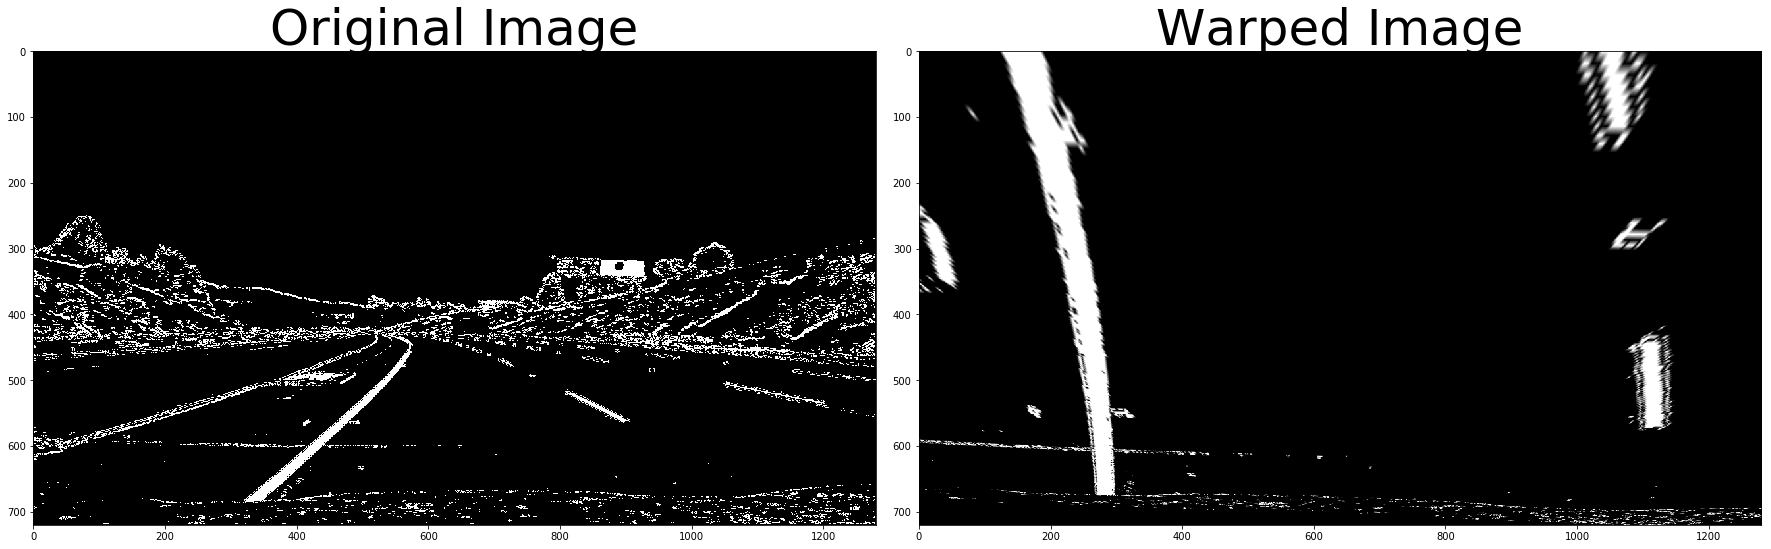

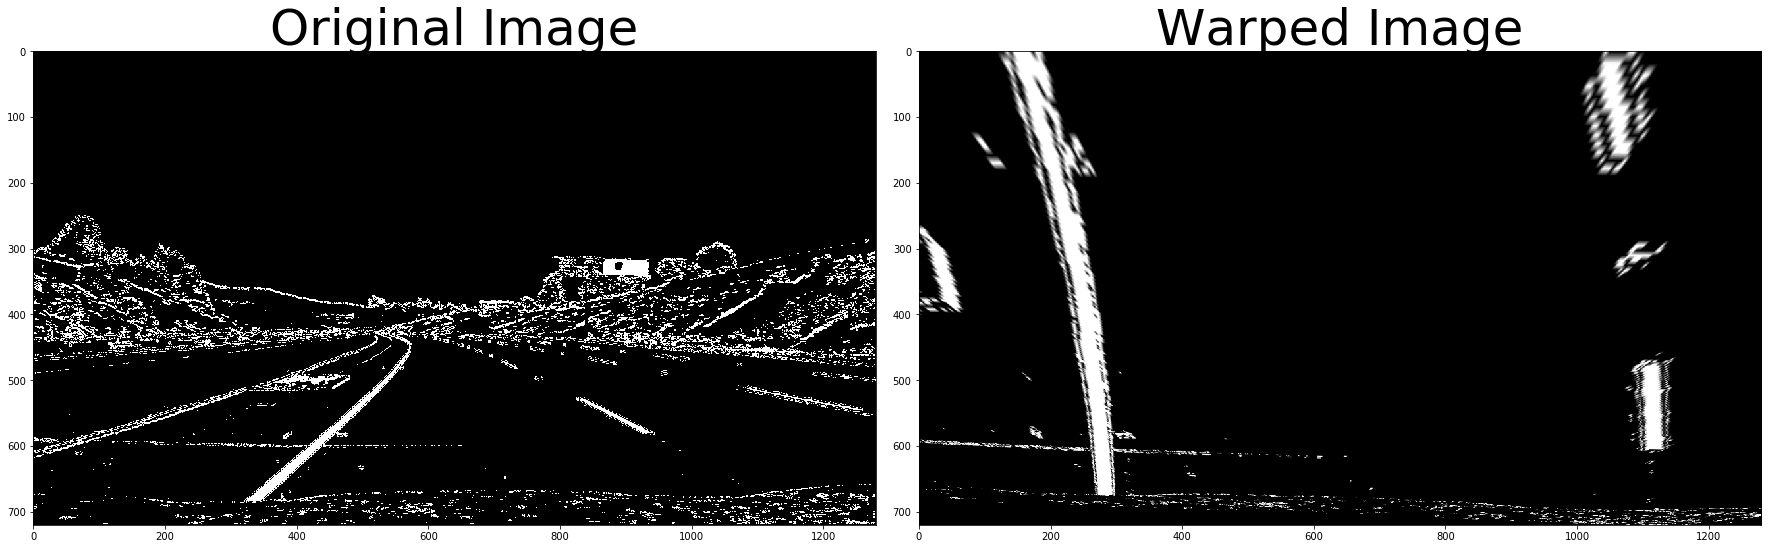

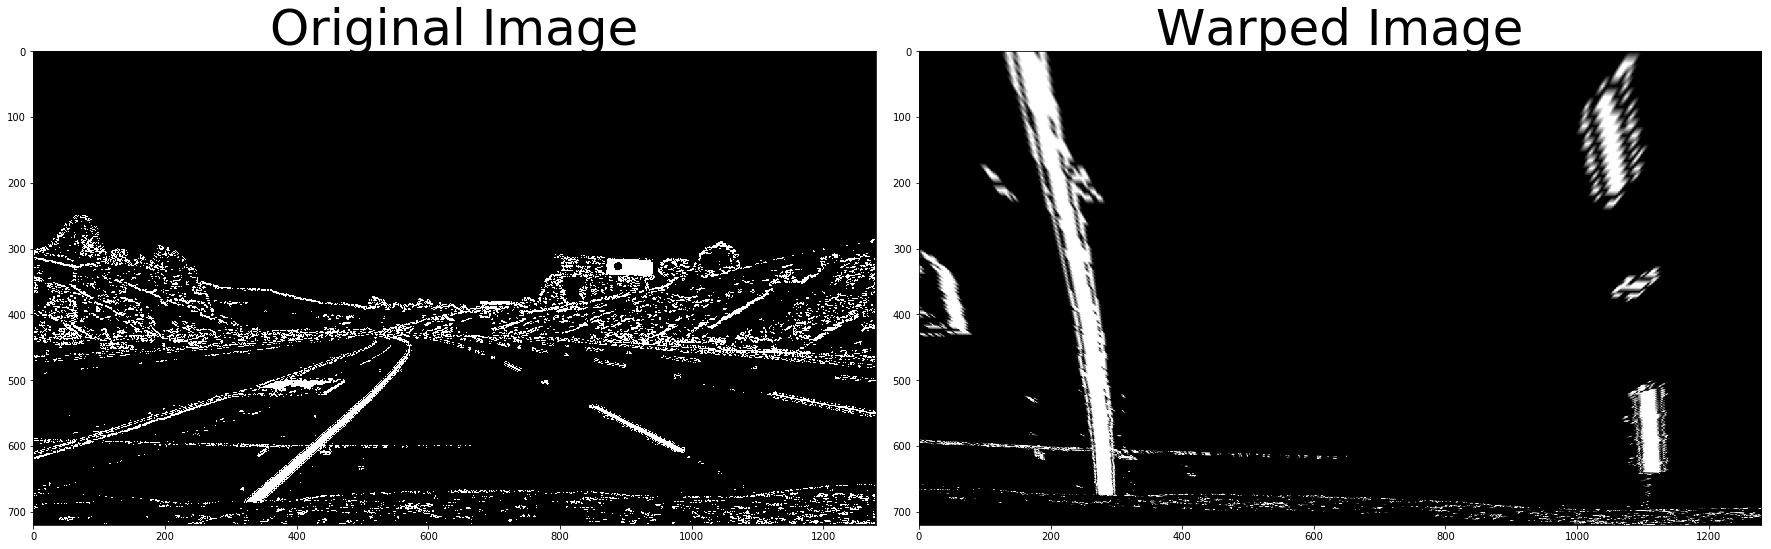

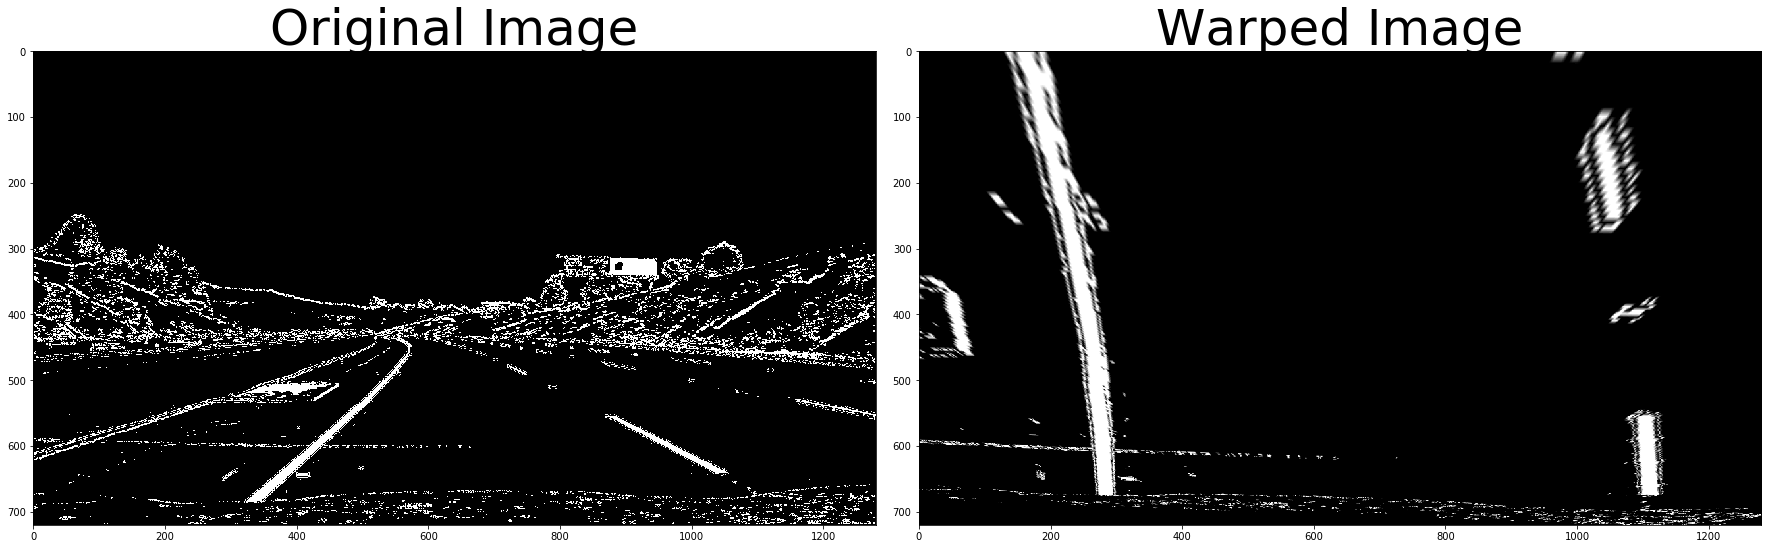

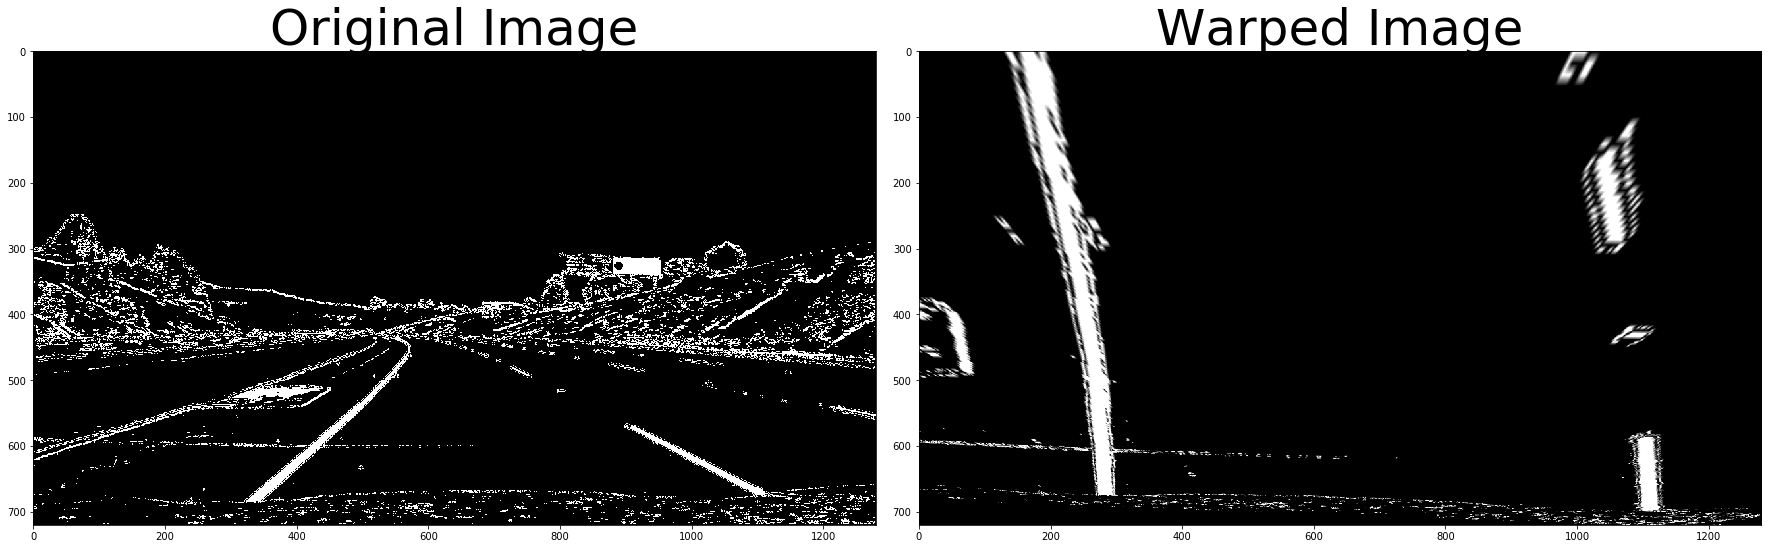

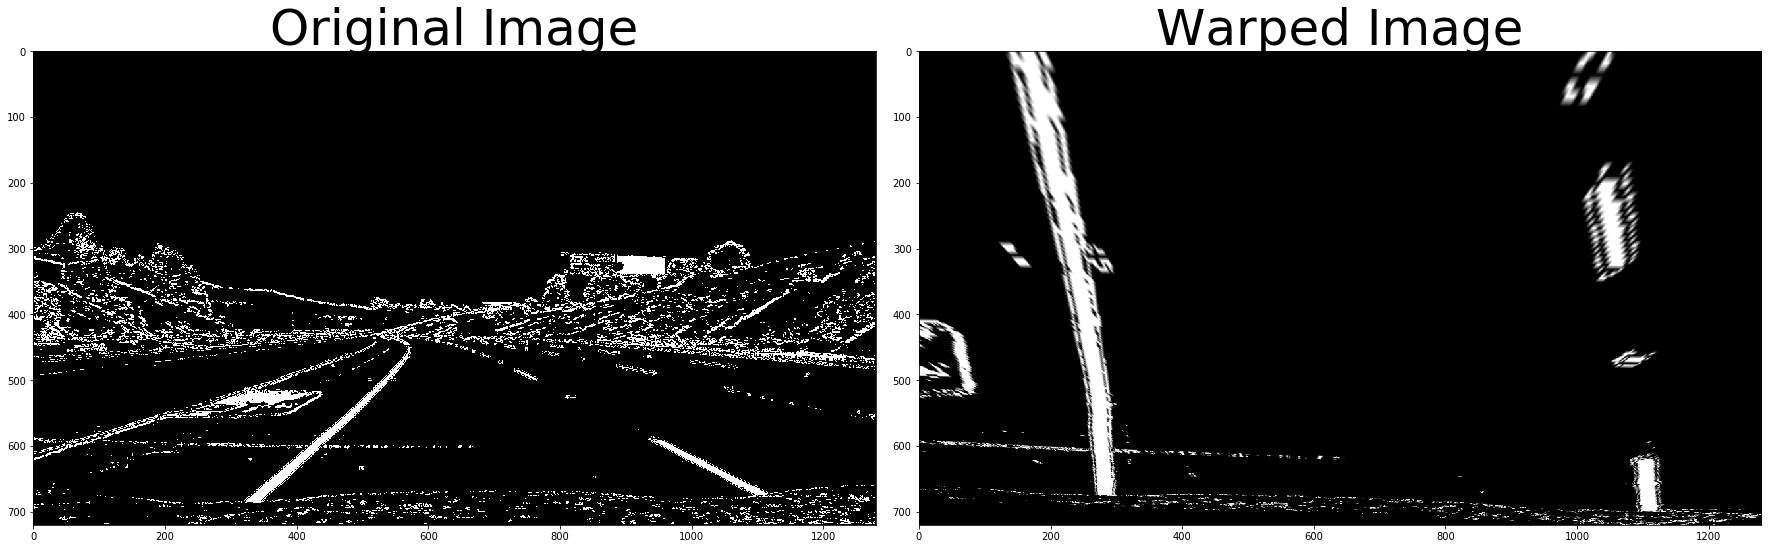

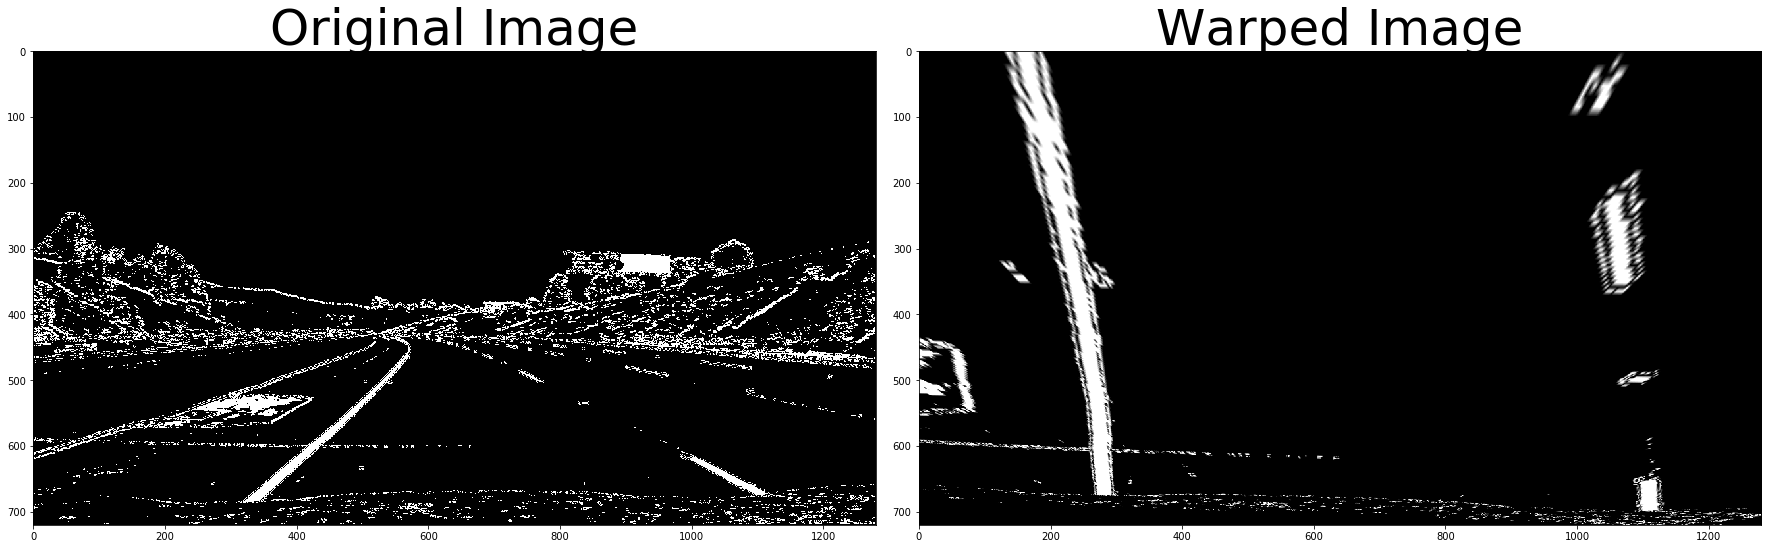

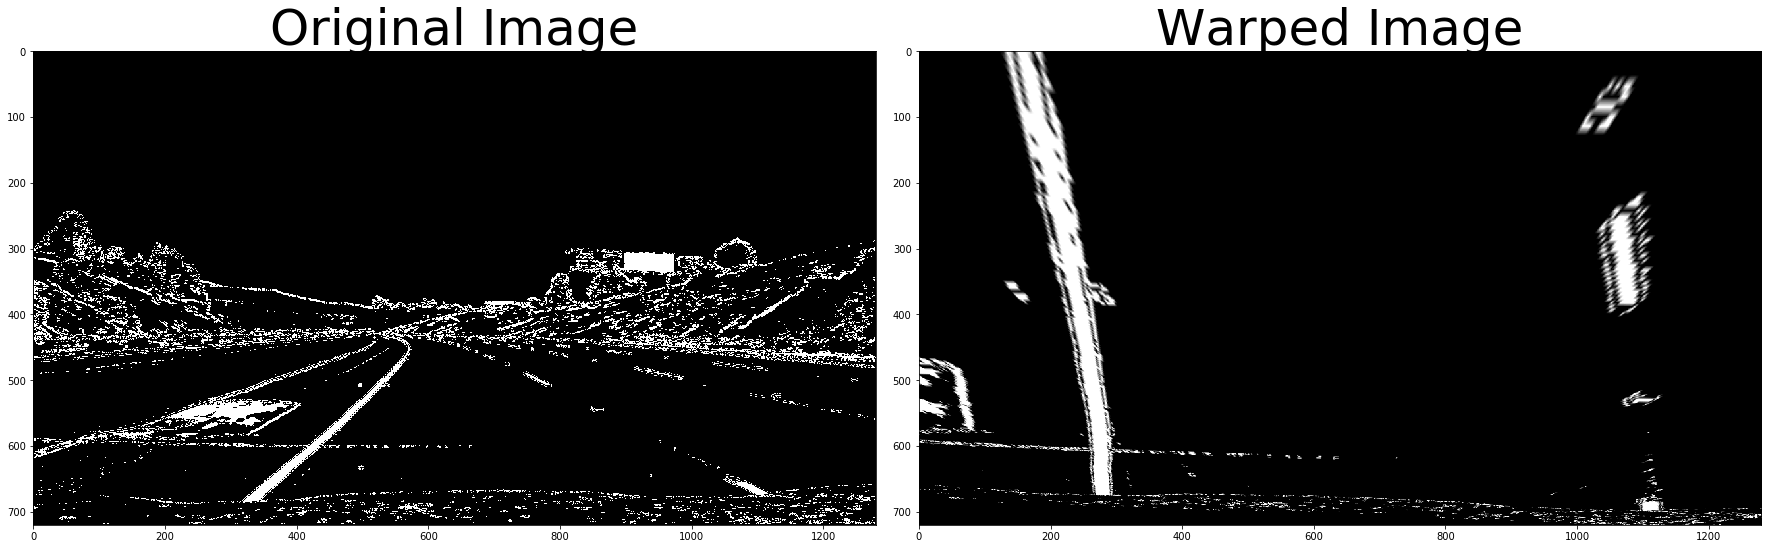

In [63]:
##warped, M = birds_eye_view(combined_binary, True)

for frame in range(0,20):
    image = mpimg.imread("../video_frames/frame%d.jpg" % frame)
    combined_binary = Color_gradient_thresholding(image, False)
    warped, M = birds_eye_view(combined_binary, True)

## STEP5: Detect lane pixels and fit to find the lane boundary.

In [64]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        print(win_xleft_low,win_y_low,win_xleft_high,win_y_high)
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 5) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low), (win_xright_high,win_y_high),(0,255,0), 5) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img